In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from datasets.lost_and_found import LostAndFound
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer


from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

In [4]:
pip install git+https://github.com/NazirNayal8/analyze.git

  Cloning https://github.com/NazirNayal8/analyze.git to /tmp/pip-req-build-zbnflq60
  Running command git clone -q https://github.com/NazirNayal8/analyze.git /tmp/pip-req-build-zbnflq60
  Resolved https://github.com/NazirNayal8/analyze.git to commit 648a08dce89c67a2cc11190cc48536f162a82764
Note: you may need to restart the kernel to use updated packages.


# PATHS

In [5]:
config_path_swin_b_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_90k.yaml'
config_path_swin_l_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_90k.yaml'
config_path_swin_s = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_small_bs16_90k.yaml'
config_path_swin_t = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_tiny_bs16_90k.yaml'
config_path_r101 = './configs/cityscapes/semantic-segmentation/maskformer2_R101_bs16_90k.yaml'


ckpt_path_swin_b_in21k = 'model_logs/mask2former_swin_b_official/model_final.pkl'
ckpt_path_swin_l_in21k = 'model_logs/swin_l_official/model_final.pkl'
ckpt_path_swin_s = './pretrained/swin_s_model_final_fa26ae.pkl'
ckpt_path_swin_t = './pretrained/swin_t_model_final_2d58d4.pkl'
ckpt_path_r101 = './pretrained/r101_model_final_257ce8.pkl'

# Loading the Model

In [6]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

args = edict({'config_file': config_path_swin_b_in21k, 'eval-only':True, 'opts':[]})
config = setup(args)

ckpt_swin_b_in21k = load_model_state_dict(ckpt_path_swin_b_in21k)

Loading config ./configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[09/02 17:23:19 detectron2]: Rank of current process: 0. World size: 1
[09/02 17:23:20 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          510.85.

[09/02 17:23:20 detectron2]: Full config saved to ./output/config.yaml
[09/02 17:23:20 d2.utils.env]: Using a generated random seed 20739924


In [7]:
model_swin_b = Trainer.build_model(config)
DetectionCheckpointer(model_swin_b, save_dir=config.OUTPUT_DIR).resume_or_load(
    ckpt_path_swin_b_in21k, resume=False
)

[09/02 17:23:29 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

[09/02 17:23:29 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_swin_b_official/model_final.pkl ...
[09/02 17:23:29 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [09/02 17:23:29 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


{'__author__': 'MaskFormer Model Zoo'}

In [8]:
model_swin_b.cuda()
_ = model_swin_b.eval()

# Params

In [9]:
image_mean = [123.675, 116.280, 103.530]
image_std = [58.395, 57.120, 57.375]

# Dataset Configs

In [10]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})

laf_config = edict(
    dataset_root='/home/user/datasets/LostAndFound',
)



# Create Datasets

In [11]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)

# Lost And Found
transforms_laf = A.Compose([
    ToTensorV2()
])

laf_dataset = LostAndFound(laf_config, transforms_laf) 
loader_laf = DataLoader(laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Util Functions

In [12]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}])
        
    return out[0]['sem_seg'].unsqueeze(0)

# Analyzing Swin B

In [23]:
analyzer_swin_b = MaxLogitsAnalyzer(model=model_swin_b, inference_func=get_logits)

## Cityscapes mIoU

In [24]:
mIoU_cityscapes_swin_b = analyzer_swin_b.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


In [25]:
mIoU_cityscapes_swin_b

tensor(0.8333)

## BDD100K mIoU

In [27]:
mIoU_bdd100k_swin_b = analyzer_swin_b.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


In [28]:
mIoU_bdd100k_swin_b

tensor(0.5574)

## Max Logits

### Road Anomaly

In [33]:
max_logits_swin_b_df = analyzer_swin_b.extract_max_logits_ood(
    loader=loader_road_anomaly,
    dataset_name='road_anomaly',
    device=torch.device('cuda'),
    skip=40
)

Loader for an OOD Dataset: 100%|██████████| 60/60 [00:09<00:00,  6.18it/s]


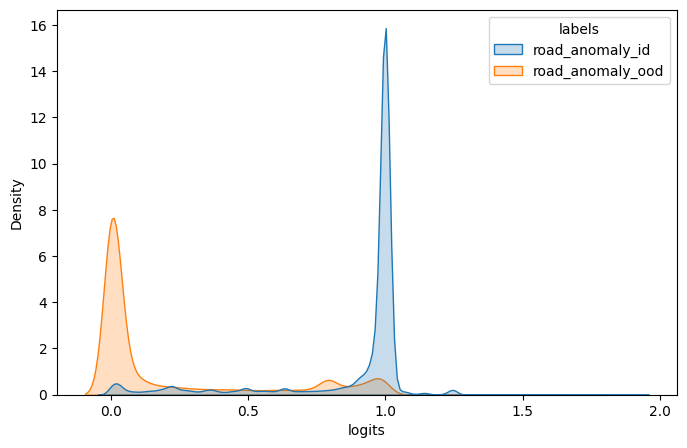

In [35]:
analyzer_swin_b.visualize_kde(max_logits_swin_b_df)

### Cityscapes

In [37]:
ml_cs_swin_b_df = analyzer_swin_b.extract_max_logits_id(
    loader=loader_cityscapes,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='cityscapes',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

Total Number of ID pixels 10486000
Per Class Pixel Frequency:
road                              3452981
sidewalk                           495918
building                          2010301
wall                                67322
fence                               75309
pole                               135951
traffic light                       18876
traffic sign                        61208
vegetation                        1588911
terrain                             76527
sky                                308035
person                             119414
rider                               20088
car                                597558
truck                               27641
bus                                 35665
train                               10327
motorcycle                           7440
bicycle                             65857
void                              1315823


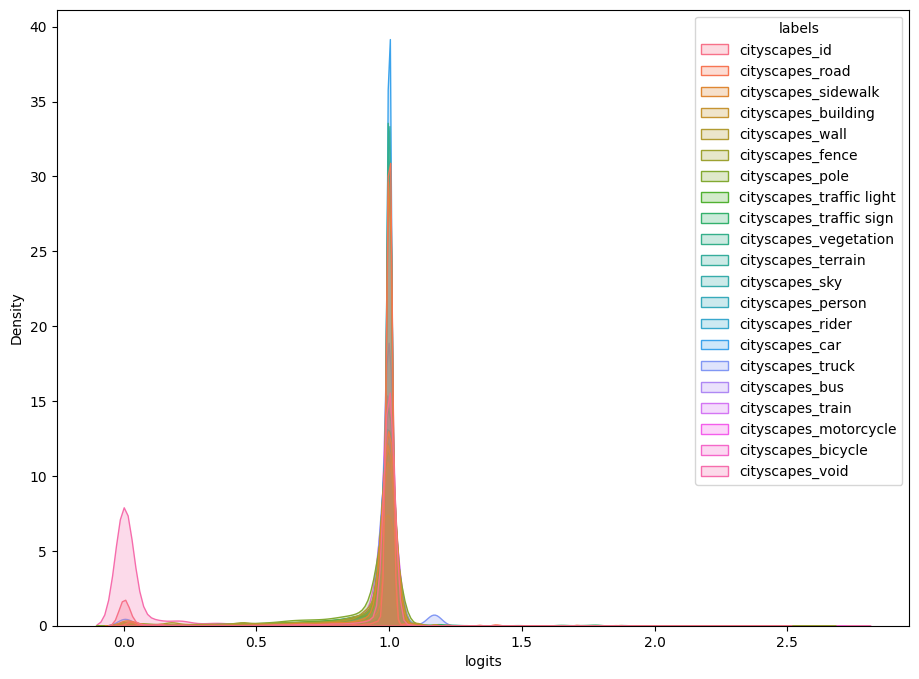

In [48]:
analyzer_swin_b.visualize_kde(ml_cs_swin_b_df, figsize=(11, 8))

In [40]:
max_logits_swin_b_df = pd.concat([max_logits_swin_b_df, ml_cs_swin_b_df], ignore_index=True)

In [44]:
max_logits_swin_b_df

,logits,labels
0,2.448876e-01,road_anomaly_ood
1,1.996892e-02,road_anomaly_ood
2,1.744382e-04,road_anomaly_ood
3,1.047258e-04,road_anomaly_ood
4,1.467500e-03,road_anomaly_ood
...,...,...
3899751,5.507989e-06,cityscapes_void
3899752,5.756742e-06,cityscapes_void
3899753,4.125536e-07,cityscapes_void
3899754,6.514292e-07,cityscapes_void


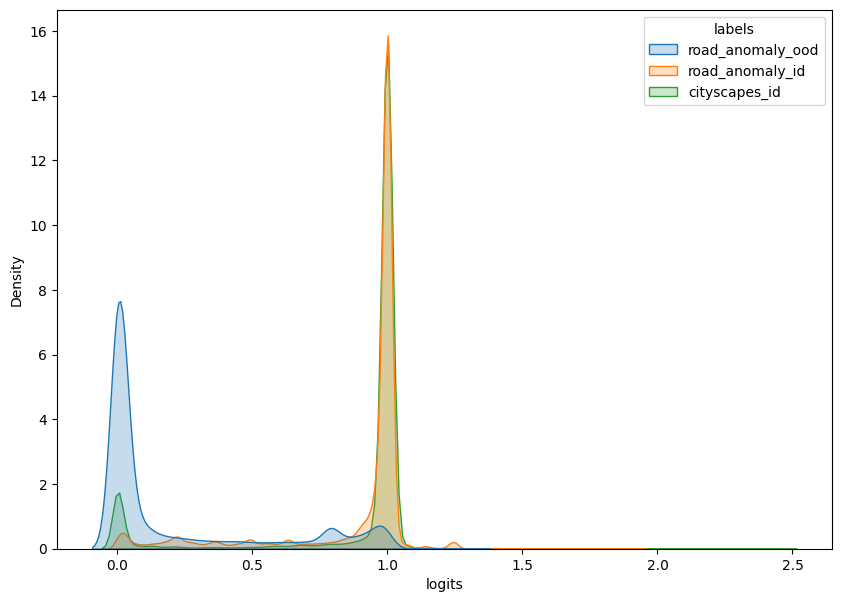

In [49]:
analyzer_swin_b.visualize_kde(
    max_logits_swin_b_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood'
    ],
    figsize=(10, 7)
)

### BDD100K

In [50]:
ml_bdd100k_swin_b_df = analyzer_swin_b.extract_max_logits_id(
    loader=loader_bdd100k,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='bdd100k',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

Total Number of ID pixels 9216000
Per Class Pixel Frequency:
road                              1991112
sidewalk                           189600
building                          1372621
wall                                32886
fence                               74389
pole                                89853
traffic light                       15095
traffic sign                        23598
vegetation                        1421968
terrain                             84567
sky                               1651353
person                              26025
rider                                1012
car                                836757
truck                               93752
bus                                 58050
train                                1093
motorcycle                           2433
bicycle                              1570
void                              1260279


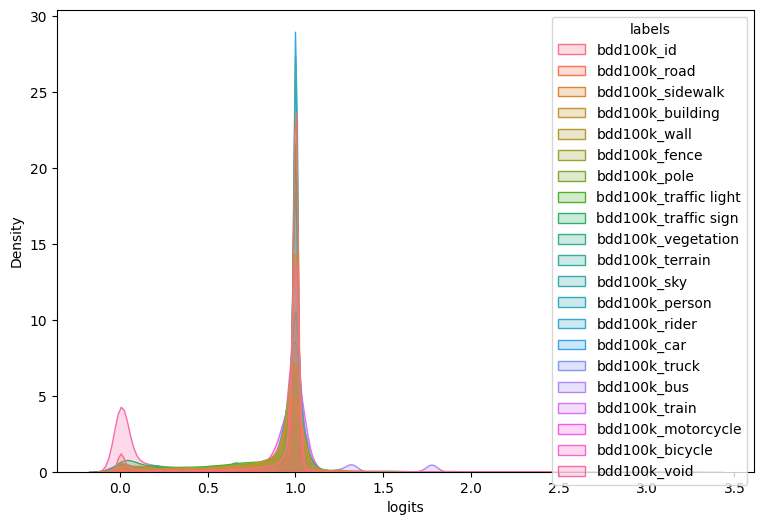

In [51]:
analyzer_swin_b.visualize_kde(ml_bdd100k_swin_b_df, figsize=(9, 6))

In [53]:
max_logits_swin_b_df = pd.concat([max_logits_swin_b_df, ml_bdd100k_swin_b_df], ignore_index=True)

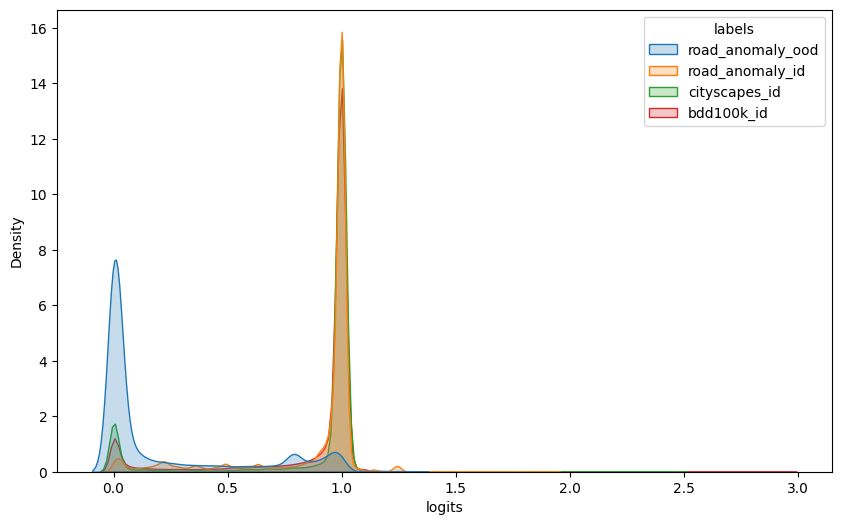

In [57]:
analyzer_swin_b.visualize_kde(
    max_logits_swin_b_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood',
        'bdd100k_id'
    ],
    figsize=(10, 6)
)

### Fishyscapes LaF

In [58]:
ml_fs_laf_swin_b_df = analyzer_swin_b.extract_max_logits_ood(
    loader=loader_fs_laf,
    dataset_name='fishyscapes_laf',
    device=torch.device('cuda'),
    skip=100
)

Loader for an OOD Dataset:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

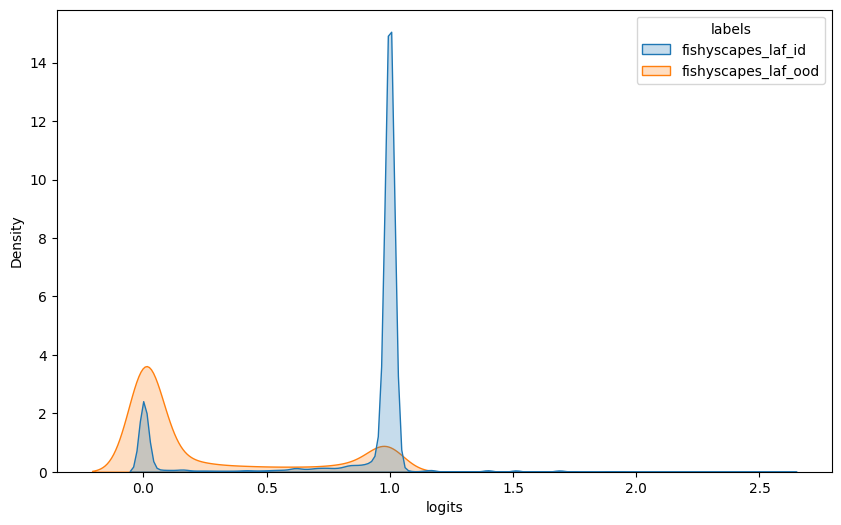

In [59]:
analyzer_swin_b.visualize_kde(ml_fs_laf_swin_b_df, figsize=(10, 6))

In [60]:
max_logits_swin_b_df = pd.concat([max_logits_swin_b_df, ml_fs_laf_swin_b_df], ignore_index=True)

In [147]:
del ml_fs_laf_swin_b_df

In [61]:
max_logits_swin_b_df.to_csv('max_logits/swin_b_cs_bdd100k_ra_fs_laf')

In [4]:
max_logits_swin_b_df = pd.read_csv('max_logits/swin_b_cs_bdd100k_ra_fs_laf')

In [5]:
analyzer_swin_b = MaxLogitsAnalyzer(model=None, inference_func=None)

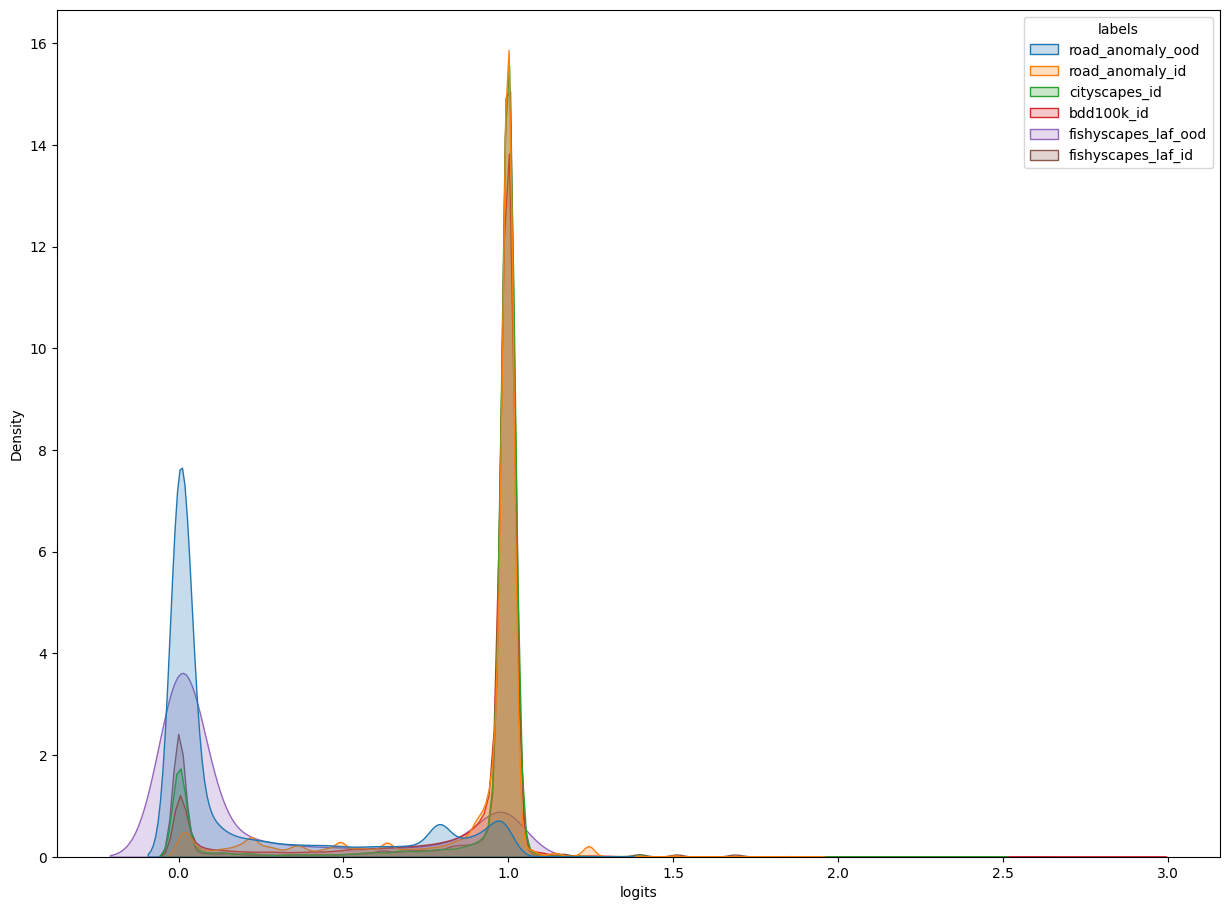

In [7]:
analyzer_swin_b.visualize_kde(
    max_logits_swin_b_df, 
    chosen_cols=[
        'road_anomaly_id',
        'road_anomaly_ood',
        'cityscapes_id',
        'bdd100k_id',
        'fishyscapes_laf_id',
        'fishyscapes_laf_ood'
    ],
    figsize=(15, 11)
)

## Evaluate on OOD

In [13]:
ood_evaluator_swin_b = OODEvaluator(model_swin_b, get_logits)

### Road Anomaly

In [110]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator_swin_b.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator_swin_b.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9408388331920094
Max Logits: AUPRC score: 0.7123278054337902
Max Logits: FPR@TPR95: 0.2612917545334929


In [99]:
imgs_ra = ood_evaluator_swin_b.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [116]:
ood_evaluator_swin_b.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_b_in21k_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.71233
OOD_test/AUROC,0.94084
OOD_test/FPR95,0.26129


### Fishyscapes LaF

In [113]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator_swin_b.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator_swin_b.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

Max Logits: AUROC score: 0.9639094442030424
Max Logits: AUPRC score: 0.48729630562764764
Max Logits: FPR@TPR95: 0.21796510712120468


In [114]:
imgs_fs_laf = ood_evaluator_swin_b.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [115]:
ood_evaluator_swin_b.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_b_in21k_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.4873
OOD_test/AUROC,0.96391
OOD_test/FPR95,0.21797


### Fishyscapes Static

In [117]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator_swin_b.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator_swin_b.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration:   0%|          | 0/30 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9492478113604061
Max Logits: AUPRC score: 0.6115922747739947
Max Logits: FPR@TPR95: 0.34614869651689495


In [118]:
imgs_fs_static = ood_evaluator_swin_b.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [119]:
ood_evaluator_swin_b.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_b_in21k_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.61159
OOD_test/AUROC,0.94925
OOD_test/FPR95,0.34615


### Lost And Found

In [14]:
anomaly_score_laf, ood_gts_laf, preds_laf = ood_evaluator_swin_b.compute_max_logit_scores(
    #loader=DataLoader(Subset(laf_dataset, np.random.choice(np.arange(len(laf_dataset)), 800, replace=False)), batch_size=1, shuffle=False, num_workers=15),
    loader=loader_laf,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=1250
)

metrics_laf = ood_evaluator_swin_b.evaluate_ood(
    anomaly_score=anomaly_score_laf,
    ood_gts=ood_gts_laf,
    verbose=True
)

Dataset Iteration:   0%|                                                                                                                                                          | 0/1203 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1203/1203 [04:54<00:00,  4.09it/s]


Calculating Metrics for 383771805 Points ...
Max Logits: AUROC score: 0.8874546977426688
Max Logits: AUPRC score: 0.27454046116870895
Max Logits: FPR@TPR95: 0.441712507815883


In [41]:
anomaly_score_laf[idx].squeeze()[800, 750]

-0.018407285

In [42]:
anomaly_score_laf[idx].squeeze()[400, 200]

-0.9996871

In [44]:
anomaly_score_laf[idx].squeeze().min()

-1.84925

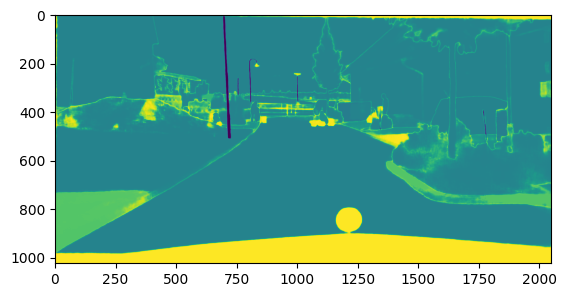

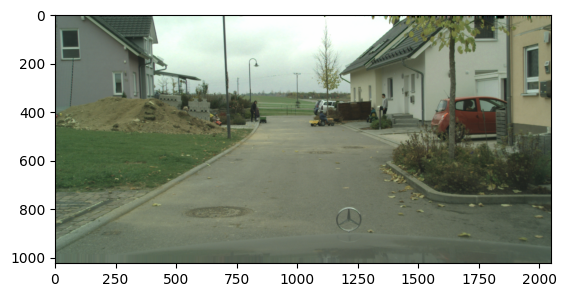

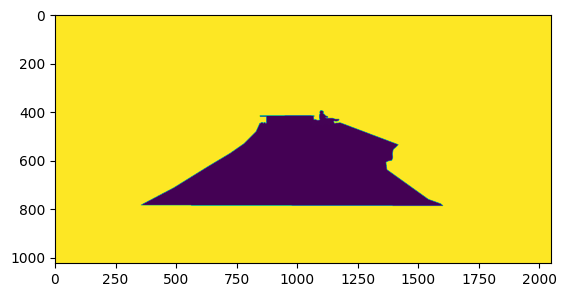

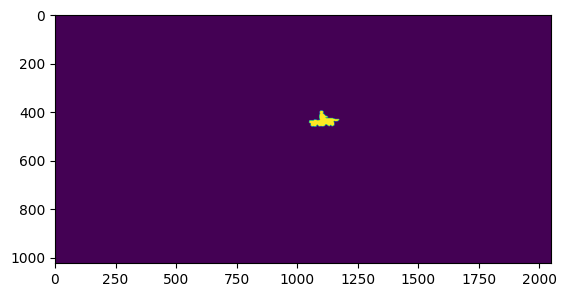

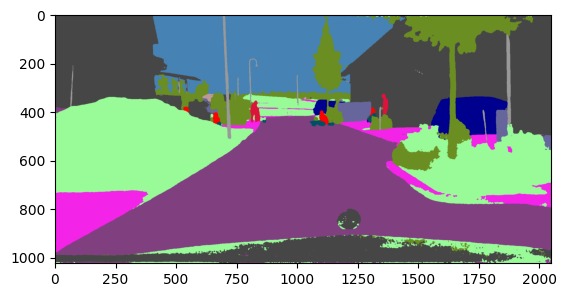

In [87]:
idx = 1072

im, lb = laf_dataset[idx]

plt.imshow(anomaly_score_laf[idx].squeeze())
plt.show()
plt.imshow(im.permute(1, 2, 0))
plt.show()
plt.imshow(laf_dataset[idx][1])
plt.show()
m = lb.clone()
k = 1
m[lb == k] = 1
m[lb != k] = 0
plt.imshow(m)
plt.show()
plt.imshow(get_seg_colormap(preds_laf[idx].squeeze(), bdd100k_dataset.colors))
plt.show()

### Road Anomaly 21 (Qualitative)

In [120]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator_swin_b.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration:   0%|          | 0/110 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

In [121]:
imgs_ra_21 = ood_evaluator_swin_b.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [128]:
ood_evaluator_swin_b.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_b_in21k_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [131]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator_swin_b.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

Dataset Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use 

In [132]:
imgs_bdd100k = ood_evaluator_swin_b.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [133]:
ood_evaluator_swin_b.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_b_in21k_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

In [134]:
del model_swin_b

In [137]:
del analyzer_swin_b

In [146]:
del max_logits_swin_b_df

# Analyzing Swin L

In [15]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

args = edict({'config_file': config_path_swin_l_in21k, 'eval-only':True, 'opts':[]})
config = setup(args)

ckpt_swin_l_in21k = load_model_state_dict(ckpt_path_swin_l_in21k)

model_swin_l = Trainer.build_model(config)
DetectionCheckpointer(model_swin_l, save_dir=config.OUTPUT_DIR).resume_or_load(
    ckpt_path_swin_l_in21k, resume=False
)

model_swin_l.cuda()
_ = model_swin_l.eval()

WARNING [09/02 16:44:29 fvcore.common.config]: Loading config ./configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[09/02 16:44:29 detectron2]: Rank of current process: 0. World size: 1
[09/02 16:44:29 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch       

[09/02 16:44:29 detectron2]: Full config saved to ./output/config.yaml
[09/02 16:44:29 d2.utils.env]: Using a generated random seed 30247226
[09/02 16:44:41 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
         

[09/02 16:44:41 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/swin_l_official/model_final.pkl ...
[09/02 16:44:42 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [09/02 16:44:42 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [10]:
analyzer_swin_l = MaxLogitsAnalyzer(model=model_swin_l, inference_func=get_logits)

## Cityscapes mIoU

In [138]:
mIoU_cityscapes_swin_l = analyzer_swin_l.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

  0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, roun

In [139]:
mIoU_cityscapes_swin_l

tensor(0.8335)

## BDD100K mIoU

In [140]:
mIoU_bdd100k_swin_l = analyzer_swin_s.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 1000/1000 [03:06<00:00,  5.37it/s]


In [141]:
mIoU_bdd100k_swin_l

tensor(0.5728)

## Max Logits

### Road Anomaly

In [11]:
max_logits_swin_s_df = analyzer_swin_l.extract_max_logits_ood(
    loader=loader_road_anomaly,
    dataset_name='road_anomaly',
    device=torch.device('cuda'),
    skip=40
)

Loader for an OOD Dataset:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

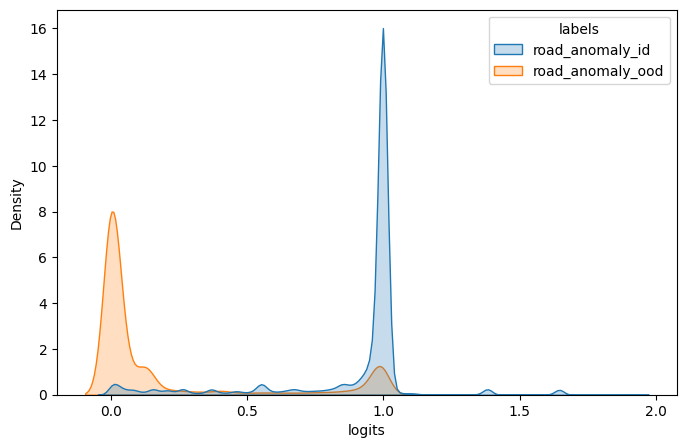

In [12]:
analyzer_swin_l.visualize_kde(max_logits_swin_l_df)

### Cityscapes

In [13]:
ml_cs_swin_l_df = analyzer_swin_l.extract_max_logits_id(
    loader=loader_cityscapes,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='cityscapes',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

Total Number of ID pixels 10486000
Per Class Pixel Frequency:
road                              3452981
sidewalk                           495918
building                          2010301
wall                                67322
fence                               75309
pole                               135951
traffic light                       18876
traffic sign                        61208
vegetation                        1588911
terrain                             76527
sky                                308035
person                             119414
rider                               20088
car                                597558
truck                               27641
bus                                 35665
train                               10327
motorcycle                           7440
bicycle                             65857
void                              1315823


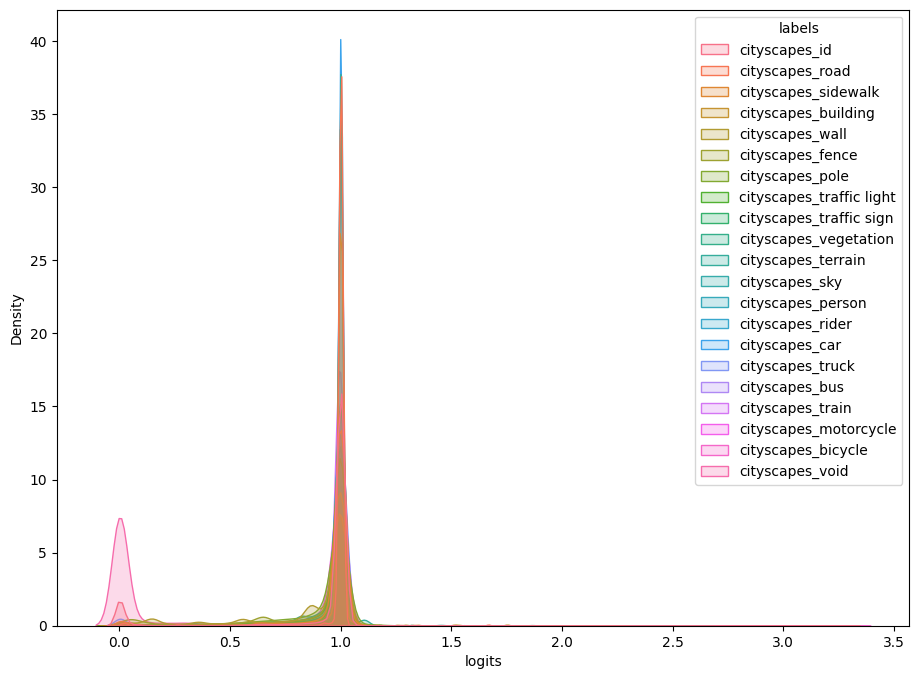

In [14]:
analyzer_swin_l.visualize_kde(ml_cs_swin_l_df, figsize=(11, 8))

In [15]:
max_logits_swin_l_df = pd.concat([max_logits_swin_l_df, ml_cs_swin_l_df], ignore_index=True)

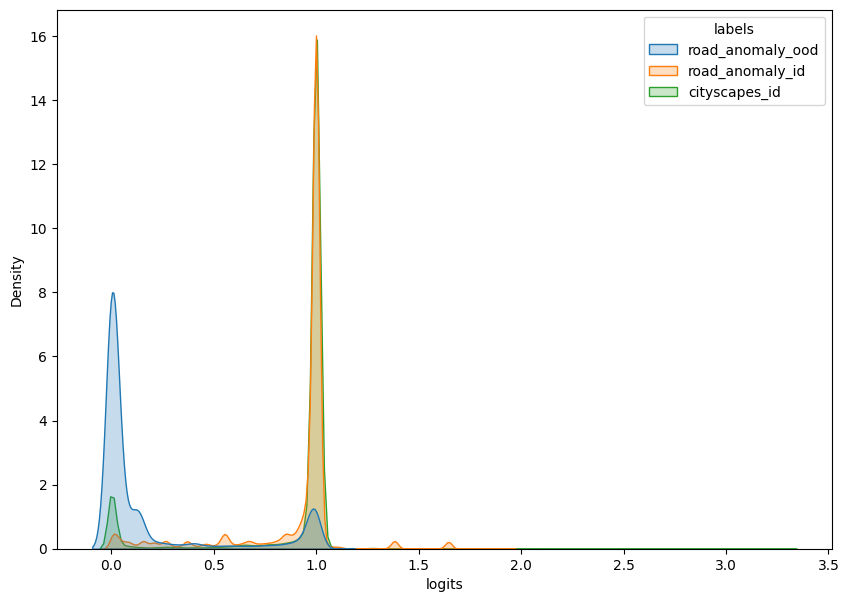

In [16]:
analyzer_swin_l.visualize_kde(
    max_logits_swin_l_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood'
    ],
    figsize=(10, 7)
)

### BDD100K

In [17]:
ml_bdd100k_swin_l_df = analyzer_swin_l.extract_max_logits_id(
    loader=loader_bdd100k,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='bdd100k',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

Total Number of ID pixels 9216000
Per Class Pixel Frequency:
road                              1991112
sidewalk                           189600
building                          1372621
wall                                32886
fence                               74389
pole                                89853
traffic light                       15095
traffic sign                        23598
vegetation                        1421968
terrain                             84567
sky                               1651353
person                              26025
rider                                1012
car                                836757
truck                               93752
bus                                 58050
train                                1093
motorcycle                           2433
bicycle                              1570
void                              1260279


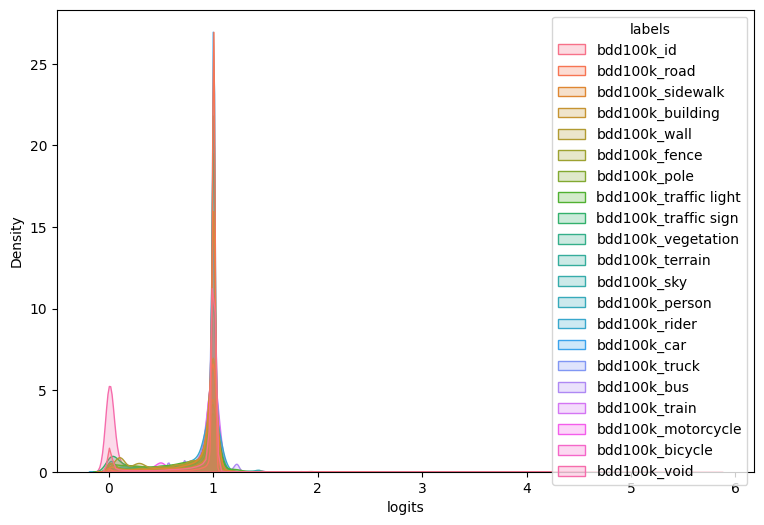

In [18]:
analyzer_swin_l.visualize_kde(ml_bdd100k_swin_l_df, figsize=(9, 6))

In [19]:
max_logits_swin_l_df = pd.concat([max_logits_swin_l_df, ml_bdd100k_swin_l_df], ignore_index=True)

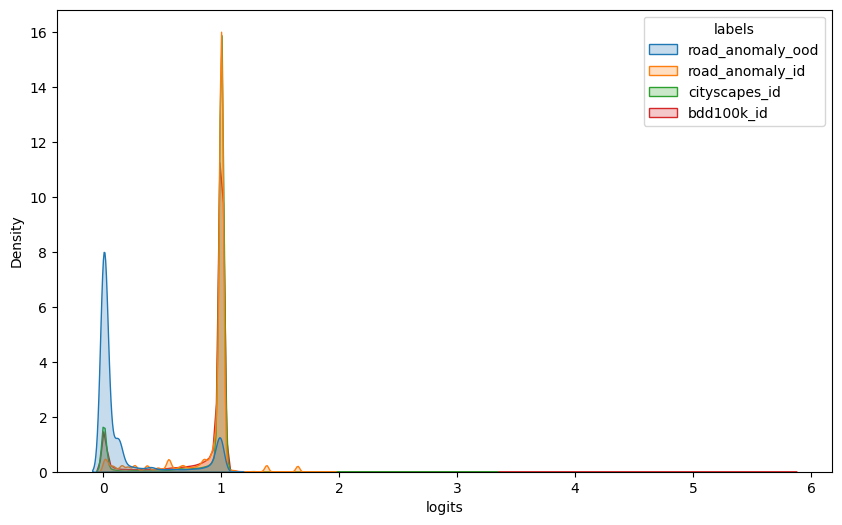

In [20]:
analyzer_swin_l.visualize_kde(
    max_logits_swin_l_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood',
        'bdd100k_id'
    ],
    figsize=(10, 6)
)

### Fishyscapes LaF

In [21]:
ml_fs_laf_swin_l_df = analyzer_swin_l.extract_max_logits_ood(
    loader=loader_fs_laf,
    dataset_name='fishyscapes_laf',
    device=torch.device('cuda'),
    skip=100
)

Loader for an OOD Dataset:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

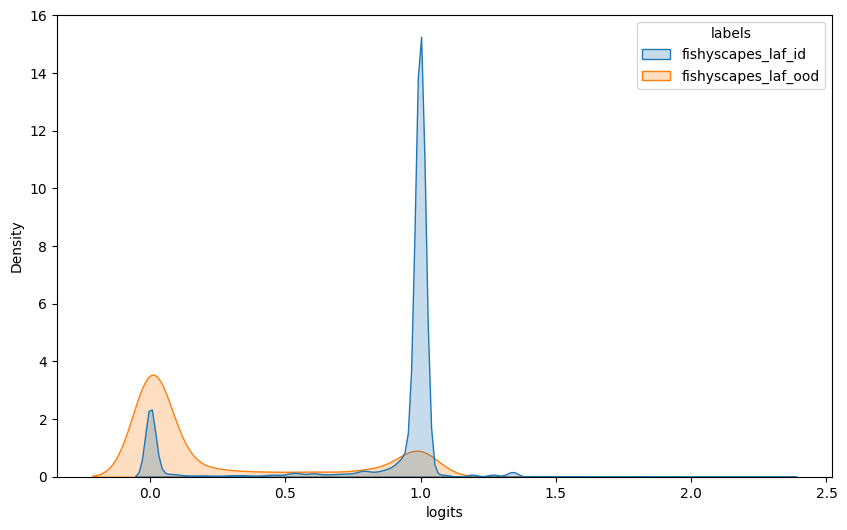

In [22]:
analyzer_swin_l.visualize_kde(ml_fs_laf_swin_l_df, figsize=(10, 6))

In [23]:
max_logits_swin_l_df = pd.concat([max_logits_swin_l_df, ml_fs_laf_swin_l_df], ignore_index=True)

In [24]:
max_logits_swin_l_df.to_csv('max_logits/swin_l_cs_bdd100k_ra_fs_laf')

## Evaluate on OOD

In [16]:
ood_evaluator_swin_l = OODEvaluator(model_swin_l, get_logits)

### Road Anomaly

In [26]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator_swin_l.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator_swin_l.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9354426757393671
Max Logits: AUPRC score: 0.7433160480205997
Max Logits: FPR@TPR95: 0.3348204489637998


In [27]:
imgs_ra = ood_evaluator_swin_l.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [28]:
ood_evaluator_swin_l.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_l_in21k_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

wandb: Currently logged in as: nazirnayal98 (use `wandb login --relogin` to force relogin)


/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/analysis/max_logits.py:368: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(20, 14))


OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.74332
OOD_test/AUROC,0.93544
OOD_test/FPR95,0.33482


### Fishyscapes LaF

In [29]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator_swin_l.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator_swin_l.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

Max Logits: AUROC score: 0.9404598887552834
Max Logits: AUPRC score: 0.4995525933795932
Max Logits: FPR@TPR95: 0.359206973416154


In [30]:
imgs_fs_laf = ood_evaluator_swin_l.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [31]:
ood_evaluator_swin_l.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_l_in21k_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.49955
OOD_test/AUROC,0.94046
OOD_test/FPR95,0.35921


### Fishyscapes Static

In [61]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator_swin_l.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator_swin_l.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.16it/s]


Calculating Metrics for 53335838 Points ...
Max Logits: AUROC score: 0.988047000181096
Max Logits: AUPRC score: 0.7354152811419936
Max Logits: FPR@TPR95: 0.05624017434554848


In [33]:
imgs_fs_static = ood_evaluator_swin_l.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [34]:
ood_evaluator_swin_l.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_l_in21k_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.57947
OOD_test/AUROC,0.9679
OOD_test/FPR95,0.14093


In [16]:
def get_seg_colormap(preds, colors):
    """
    Assuming preds.shape = (H,W)
    """
    H, W = preds.shape
    color_map = torch.zeros((H, W, 3)).long()
    
    for i in range(len(colors)):
        mask = (preds == i)
        if mask.sum() == 0:
            continue
        color_map[mask, :] = torch.tensor(colors[i])
    
    return color_map

### Lost And Found

In [18]:
anomaly_score_laf, ood_gts_laf, preds_laf = ood_evaluator_swin_l.compute_max_logit_scores(
    #loader=DataLoader(Subset(laf_dataset, np.random.choice(np.arange(len(laf_dataset)), 800, replace=False)), batch_size=1, shuffle=False, num_workers=15),
    loader=loader_laf,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=1250
)

metrics_laf = ood_evaluator_swin_l.evaluate_ood(
    anomaly_score=anomaly_score_laf,
    ood_gts=ood_gts_laf,
    verbose=True
)

Calculating Metrics for 383771805 Points ...
Max Logits: AUROC score: 0.8636287408200627
Max Logits: AUPRC score: 0.14849245300889027
Max Logits: FPR@TPR95: 0.5864425880736848


In [40]:
anomaly_score_laf[idx].squeeze()[800, 750]

-0.0022153372

In [45]:
anomaly_score_laf[idx].squeeze()[400, 200]

-0.99345964

In [44]:
anomaly_score_laf[idx].squeeze().min()

-1.84925

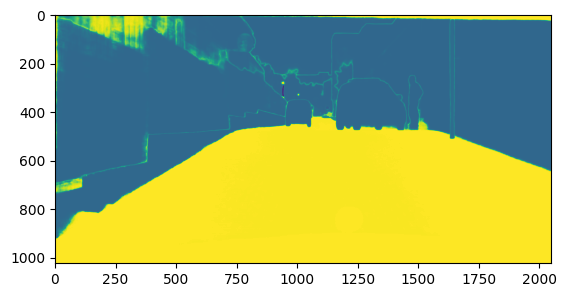

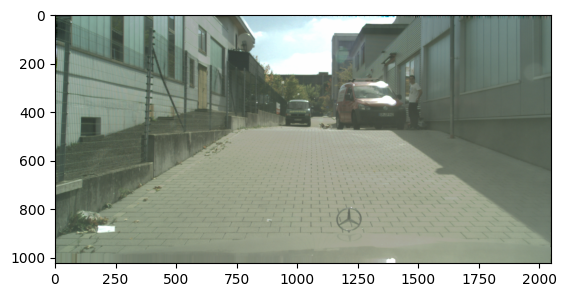

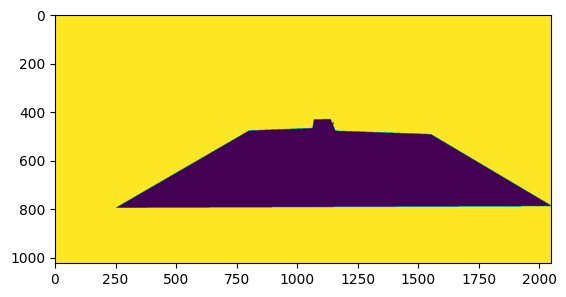

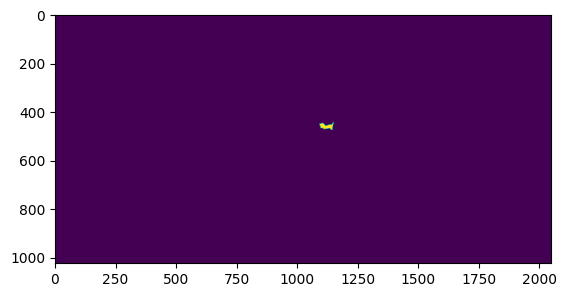

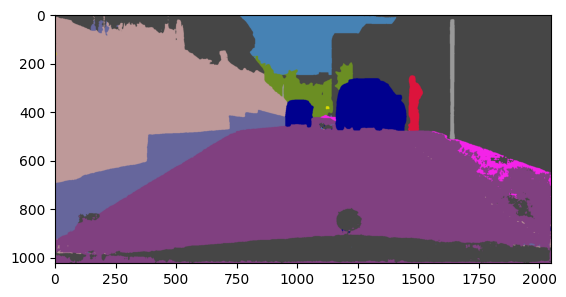

In [66]:
idx = 62

im, lb = laf_dataset[idx]

plt.imshow(anomaly_score_laf[idx].squeeze())
plt.show()
plt.imshow(im.permute(1, 2, 0))
plt.show()
plt.imshow(laf_dataset[idx][1])
plt.show()
m = lb.clone()
k = 1
m[lb == k] = 1
m[lb != k] = 0
plt.imshow(m)
plt.show()
plt.imshow(get_seg_colormap(preds_laf[idx].squeeze(), bdd100k_dataset.colors))

### Road Anomaly 21 (Qualitative)

In [35]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator_swin_l.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration:   0%|          | 0/110 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

In [36]:
imgs_ra_21 = ood_evaluator_swin_l.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [37]:
ood_evaluator_swin_l.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_l_in21k_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [38]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator_swin_l.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

Dataset Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use 

In [39]:
imgs_bdd100k = ood_evaluator_swin_l.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [40]:
ood_evaluator_swin_l.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_l_in21k_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

In [41]:
del model_swin_l

In [42]:
del analyzer_swin_l

In [43]:
del max_logits_swin_l_df

# Analyzing Swin S

In [44]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

args = edict({'config_file': config_path_swin_s, 'eval-only':True, 'opts':[]})
config = setup(args)

ckpt_swin_s = load_model_state_dict(ckpt_path_swin_s)

model_swin_s = Trainer.build_model(config)
DetectionCheckpointer(model_swin_s, save_dir=config.OUTPUT_DIR).resume_or_load(
    ckpt_path_swin_s, resume=False
)

model_swin_s.cuda()
_ = model_swin_s.eval()

WARNING [07/18 22:12:54 fvcore.common.config]: Loading config configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[07/18 22:12:54 detectron2]: Rank of current process: 0. World size: 1
[07/18 22:12:56 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
numpy                   1.19.0
detectron2              0.6 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu113 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-pack

[07/18 22:12:56 detectron2]: Full config saved to ./output/config.yaml
[07/18 22:12:56 d2.utils.env]: Using a generated random seed 59936701
[07/18 22:13:00 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (dr

[07/18 22:13:00 fvcore.common.checkpoint]: [Checkpointer] Loading from ./pretrained/swin_s_model_final_fa26ae.pkl ...
[07/18 22:13:00 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [07/18 22:13:00 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [45]:
analyzer_swin_s = MaxLogitsAnalyzer(model=model_swin_s, inference_func=get_logits)

## Cityscapes mIoU

In [46]:
mIoU_cityscapes_swin_s = analyzer_swin_s.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

  0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, roun

In [47]:
mIoU_cityscapes_swin_s

tensor(0.8257)

## BDD100K mIoU

In [48]:
mIoU_bdd100k_swin_s = analyzer_swin_s.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


In [49]:
mIoU_bdd100k_swin_s

tensor(0.5153)

## Max Logits

### Road Anomaly

In [52]:
max_logits_swin_s_df = analyzer_swin_s.extract_max_logits_ood(
    loader=loader_road_anomaly,
    dataset_name='road_anomaly',
    device=torch.device('cuda'),
    skip=40
)

Loader for an OOD Dataset:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

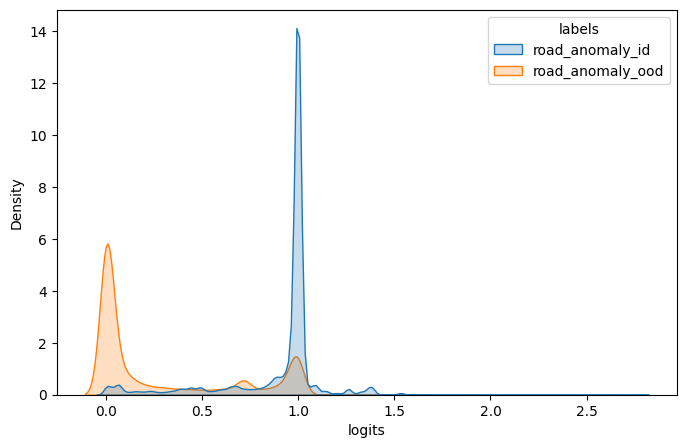

In [53]:
analyzer_swin_s.visualize_kde(max_logits_swin_s_df)

### Cityscapes

In [54]:
ml_cs_swin_s_df = analyzer_swin_s.extract_max_logits_id(
    loader=loader_cityscapes,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='cityscapes',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

Total Number of ID pixels 10486000
Per Class Pixel Frequency:
road                              3452981
sidewalk                           495918
building                          2010301
wall                                67322
fence                               75309
pole                               135951
traffic light                       18876
traffic sign                        61208
vegetation                        1588911
terrain                             76527
sky                                308035
person                             119414
rider                               20088
car                                597558
truck                               27641
bus                                 35665
train                               10327
motorcycle                           7440
bicycle                             65857
void                              1315823


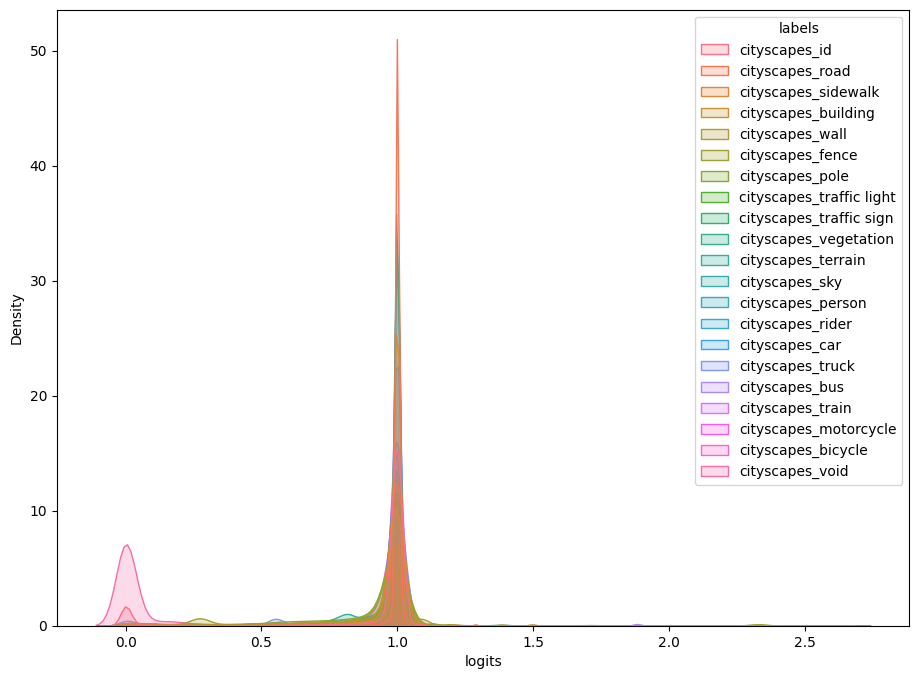

In [55]:
analyzer_swin_s.visualize_kde(ml_cs_swin_s_df, figsize=(11, 8))

In [56]:
max_logits_swin_s_df = pd.concat([max_logits_swin_s_df, ml_cs_swin_s_df], ignore_index=True)

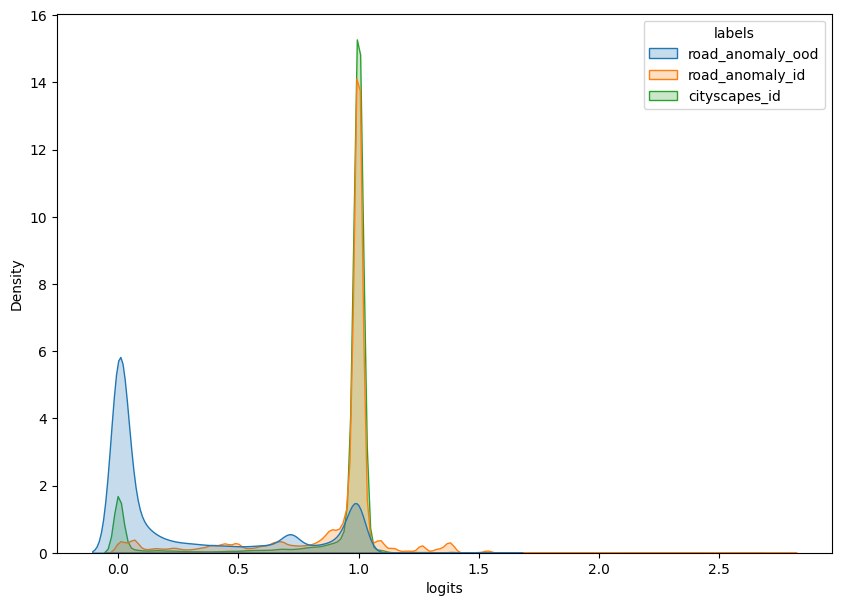

In [57]:
analyzer_swin_s.visualize_kde(
    max_logits_swin_s_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood'
    ],
    figsize=(10, 7)
)

### BDD100K

In [58]:
ml_bdd100k_swin_s_df = analyzer_swin_s.extract_max_logits_id(
    loader=loader_bdd100k,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='bdd100k',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

Total Number of ID pixels 9216000
Per Class Pixel Frequency:
road                              1991112
sidewalk                           189600
building                          1372621
wall                                32886
fence                               74389
pole                                89853
traffic light                       15095
traffic sign                        23598
vegetation                        1421968
terrain                             84567
sky                               1651353
person                              26025
rider                                1012
car                                836757
truck                               93752
bus                                 58050
train                                1093
motorcycle                           2433
bicycle                              1570
void                              1260279


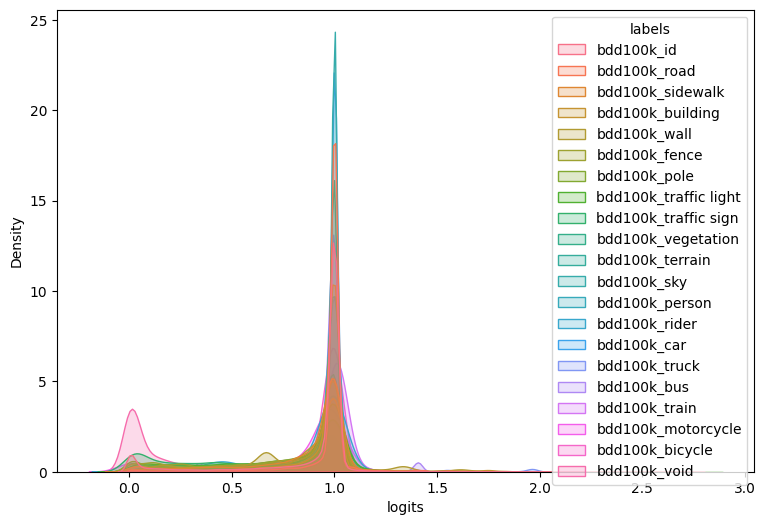

In [59]:
analyzer_swin_s.visualize_kde(ml_bdd100k_swin_s_df, figsize=(9, 6))

In [60]:
max_logits_swin_s_df = pd.concat([max_logits_swin_s_df, ml_bdd100k_swin_s_df], ignore_index=True)

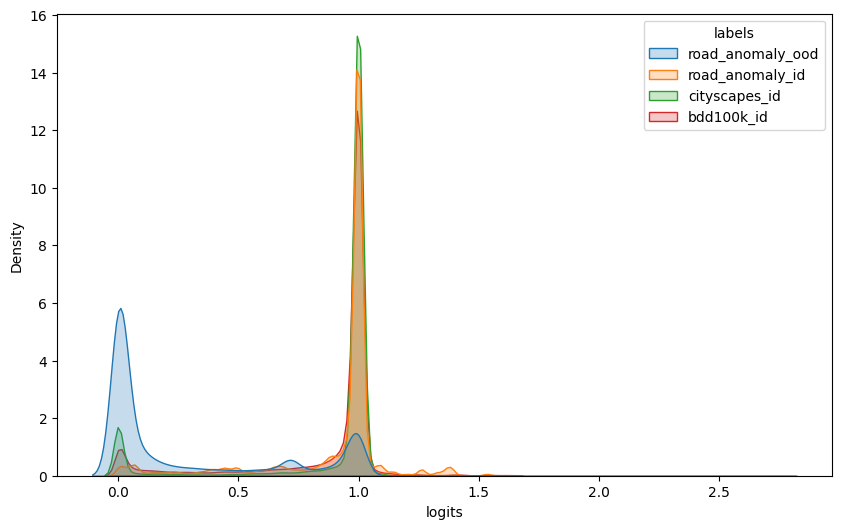

In [61]:
analyzer_swin_s.visualize_kde(
    max_logits_swin_s_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood',
        'bdd100k_id'
    ],
    figsize=(10, 6)
)

### Fishyscapes LaF

In [62]:
ml_fs_laf_swin_s_df = analyzer_swin_s.extract_max_logits_ood(
    loader=loader_fs_laf,
    dataset_name='fishyscapes_laf',
    device=torch.device('cuda'),
    skip=100
)

Loader for an OOD Dataset:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

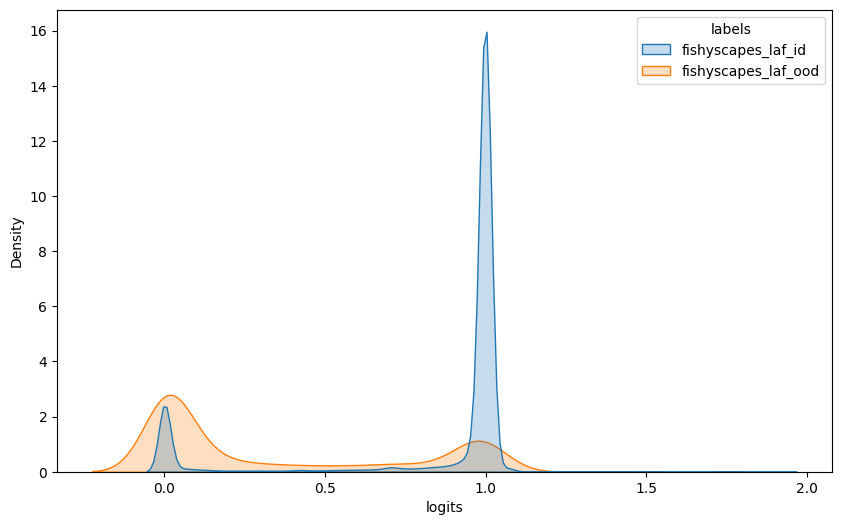

In [63]:
analyzer_swin_s.visualize_kde(ml_fs_laf_swin_s_df, figsize=(10, 6))

In [64]:
max_logits_swin_s_df = pd.concat([max_logits_swin_s_df, ml_fs_laf_swin_s_df], ignore_index=True)

In [65]:
max_logits_swin_s_df.to_csv('max_logits/swin_s_cs_bdd100k_ra_fs_laf')

## Evaluate on OOD

In [66]:
ood_evaluator_swin_s = OODEvaluator(model_swin_s, get_logits)

### Road Anomaly

In [67]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator_swin_s.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator_swin_s.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9066049725850265
Max Logits: AUPRC score: 0.6509391104356206
Max Logits: FPR@TPR95: 0.4302881932602571


In [68]:
imgs_ra = ood_evaluator_swin_s.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [69]:
ood_evaluator_swin_s.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_s_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/analysis/max_logits.py:368: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(20, 14))


OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.65094
OOD_test/AUROC,0.9066
OOD_test/FPR95,0.43029


### Fishyscapes LaF

In [70]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator_swin_s.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator_swin_s.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

Max Logits: AUROC score: 0.9356645721141239
Max Logits: AUPRC score: 0.3093758034544502
Max Logits: FPR@TPR95: 0.36825127664958657


In [71]:
imgs_fs_laf = ood_evaluator_swin_s.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [72]:
ood_evaluator_swin_s.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_s_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.30938
OOD_test/AUROC,0.93566
OOD_test/FPR95,0.36825


### Fishyscapes Static

In [73]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator_swin_s.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator_swin_s.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration:   0%|          | 0/30 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9775422676259544
Max Logits: AUPRC score: 0.5997183718749831
Max Logits: FPR@TPR95: 0.09890418865820837


In [74]:
imgs_fs_static = ood_evaluator_swin_s.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [75]:
ood_evaluator_swin_s.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_s_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.59972
OOD_test/AUROC,0.97754
OOD_test/FPR95,0.0989


### Road Anomaly 21 (Qualitative)

In [76]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator_swin_s.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration:   0%|          | 0/110 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

In [77]:
imgs_ra_21 = ood_evaluator_swin_s.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [78]:
ood_evaluator_swin_s.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_s_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [79]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator_swin_s.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

Dataset Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use 

KeyboardInterrupt: 

In [ ]:
imgs_bdd100k = ood_evaluator_swin_s.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator_swin_s.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_s_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

In [80]:
del model_swin_s

In [81]:
del analyzer_swin_s

In [82]:
del max_logits_swin_s_df

# Analyzing ResNet101

In [87]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

args = edict({'config_file': config_path_r101, 'eval-only':True, 'opts':[]})
config = setup(args)

ckpt_r101 = load_model_state_dict(ckpt_path_r101)

model_r101 = Trainer.build_model(config)
DetectionCheckpointer(model_r101, save_dir=config.OUTPUT_DIR).resume_or_load(
    ckpt_path_r101, resume=False
)

model_r101.cuda()
_ = model_r101.eval()

WARNING [07/18 22:41:35 fvcore.common.config]: Loading config ./configs/cityscapes/semantic-segmentation/Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[07/18 22:41:36 detectron2]: Rank of current process: 0. World size: 1
[07/18 22:41:38 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
numpy                   1.19.0
detectron2              0.6 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu113 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/t

[07/18 22:41:38 detectron2]: Full config saved to ./output/config.yaml
[07/18 22:41:38 d2.utils.env]: Using a generated random seed 41545780
[07/18 22:41:38 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): SyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

[07/18 22:41:38 fvcore.common.checkpoint]: [Checkpointer] Loading from ./pretrained/r101_model_final_257ce8.pkl ...
[07/18 22:41:39 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [07/18 22:41:39 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [88]:
analyzer_r101 = MaxLogitsAnalyzer(model=model_r101, inference_func=get_logits)

## Cityscapes mIoU

In [89]:
mIoU_cityscapes_r101 = analyzer_r101.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 500/500 [01:29<00:00,  5.57it/s]


In [90]:
mIoU_cityscapes_r101

tensor(0.8011)

## BDD100K mIoU

In [91]:
mIoU_bdd100k_r101 = analyzer_r101.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


In [92]:
mIoU_bdd100k_r101

tensor(0.4911)

## Max Logits

### Road Anomaly

In [95]:
max_logits_r101_df = analyzer_r101.extract_max_logits_ood(
    loader=loader_road_anomaly,
    dataset_name='road_anomaly',
    device=torch.device('cuda'),
    skip=40
)

Loader for an OOD Dataset:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

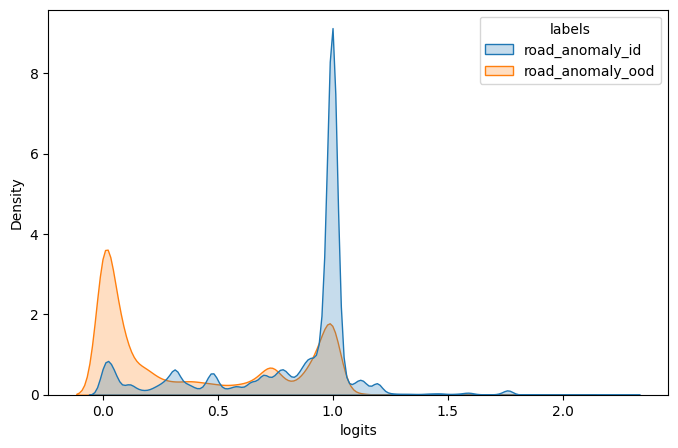

In [96]:
analyzer_r101.visualize_kde(max_logits_r101_df)

### Cityscapes

In [97]:
ml_cs_r101_df = analyzer_r101.extract_max_logits_id(
    loader=loader_cityscapes,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='cityscapes',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/500 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior

Total Number of ID pixels 10486000
Per Class Pixel Frequency:
road                              3452981
sidewalk                           495918
building                          2010301
wall                                67322
fence                               75309
pole                               135951
traffic light                       18876
traffic sign                        61208
vegetation                        1588911
terrain                             76527
sky                                308035
person                             119414
rider                               20088
car                                597558
truck                               27641
bus                                 35665
train                               10327
motorcycle                           7440
bicycle                             65857
void                              1315823


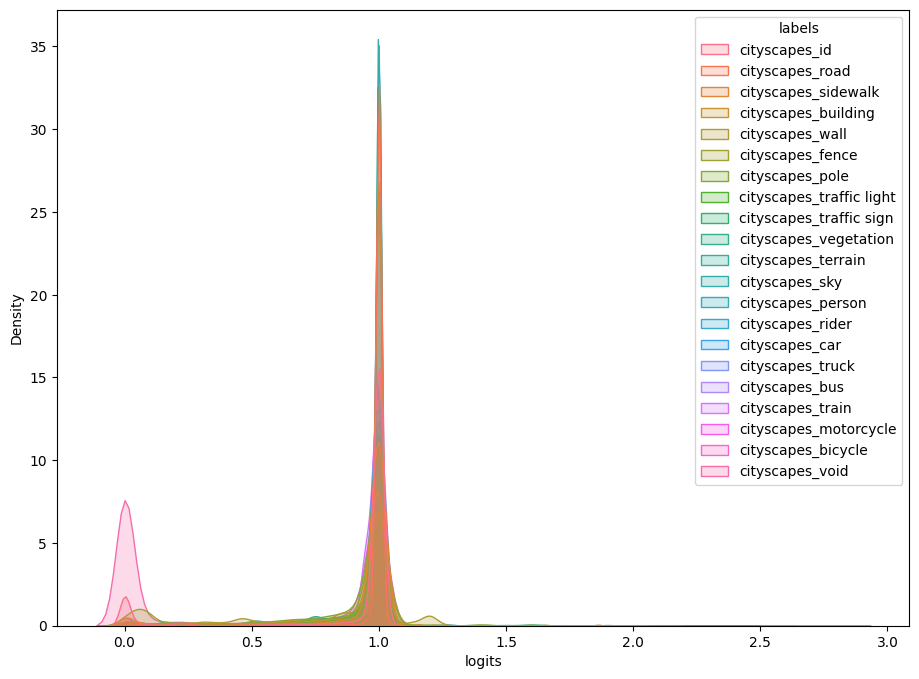

In [98]:
analyzer_r101.visualize_kde(ml_cs_r101_df, figsize=(11, 8))

In [99]:
max_logits_r101_df = pd.concat([max_logits_r101_df, ml_cs_r101_df], ignore_index=True)

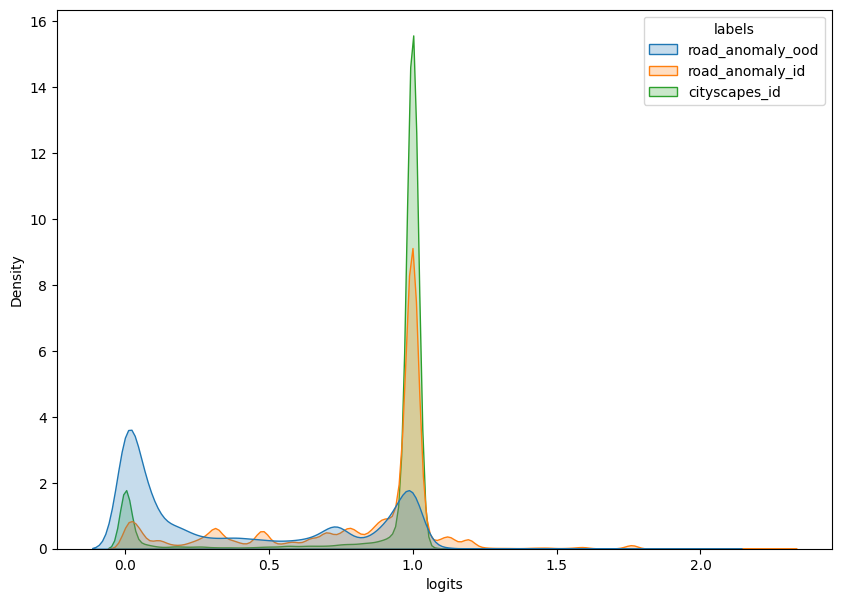

In [100]:
analyzer_r101.visualize_kde(
    max_logits_r101_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood'
    ],
    figsize=(10, 7)
)

### BDD100K

In [101]:
ml_bdd100k_r101_df = analyzer_r101.extract_max_logits_id(
    loader=loader_bdd100k,
    num_classes=20,
    class_names=bdd100k_dataset.class_names,
    dataset_name='bdd100k',
    device=torch.device('cuda'),
    skip=10,
    id_skip=100,
)

Loader for an ID Dataset:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

Total Number of ID pixels 9216000
Per Class Pixel Frequency:
road                              1991112
sidewalk                           189600
building                          1372621
wall                                32886
fence                               74389
pole                                89853
traffic light                       15095
traffic sign                        23598
vegetation                        1421968
terrain                             84567
sky                               1651353
person                              26025
rider                                1012
car                                836757
truck                               93752
bus                                 58050
train                                1093
motorcycle                           2433
bicycle                              1570
void                              1260279


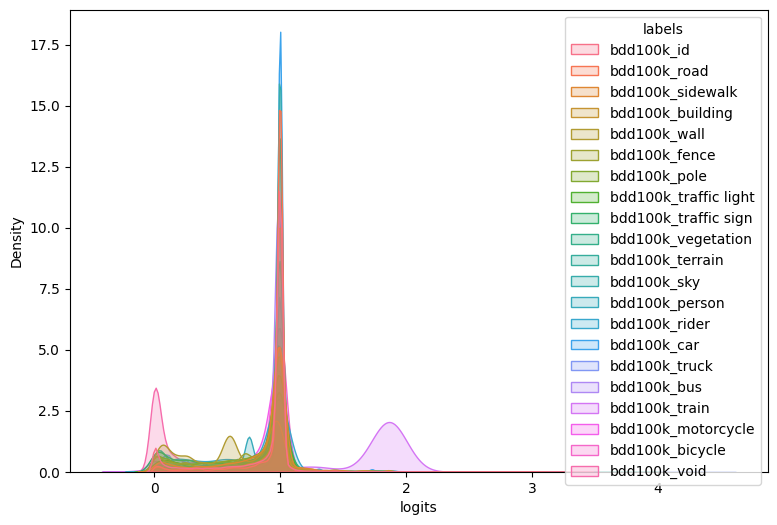

In [102]:
analyzer_r101.visualize_kde(ml_bdd100k_r101_df, figsize=(9, 6))

In [103]:
max_logits_r101_df = pd.concat([max_logits_r101_df, ml_bdd100k_r101_df], ignore_index=True)

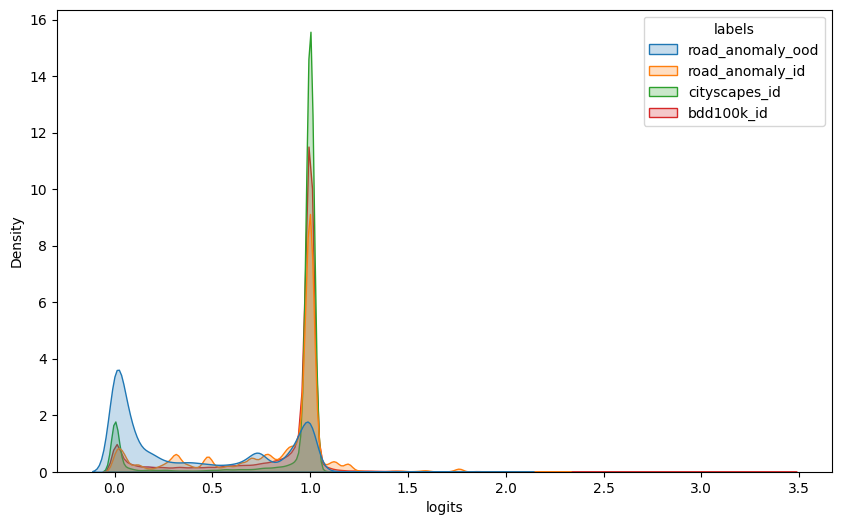

In [104]:
analyzer_r101.visualize_kde(
    max_logits_r101_df, 
    chosen_cols=[
        'cityscapes_id',
        'road_anomaly_id',
        'road_anomaly_ood',
        'bdd100k_id'
    ],
    figsize=(10, 6)
)

### Fishyscapes LaF

In [105]:
ml_fs_laf_r101_df = analyzer_r101.extract_max_logits_ood(
    loader=loader_fs_laf,
    dataset_name='fishyscapes_laf',
    device=torch.device('cuda'),
    skip=100
)

Loader for an OOD Dataset:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavio

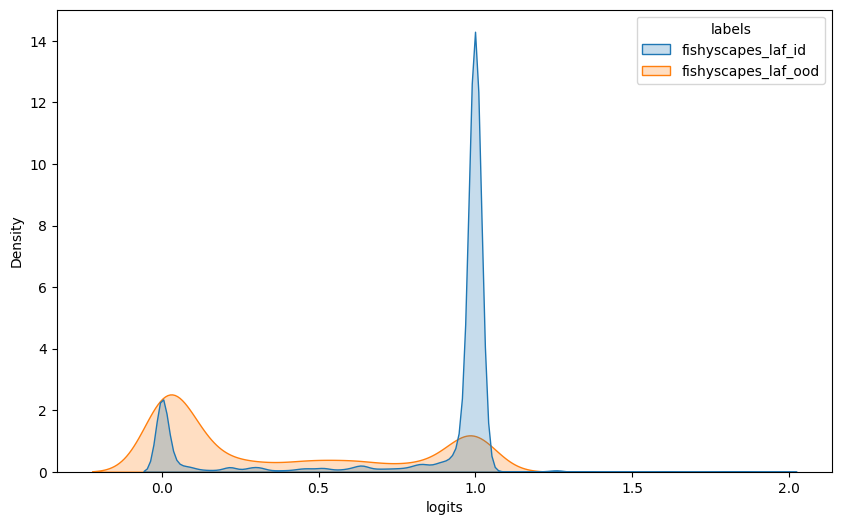

In [106]:
analyzer_r101.visualize_kde(ml_fs_laf_r101_df, figsize=(10, 6))

In [107]:
max_logits_r101_df = pd.concat([max_logits_r101_df, ml_fs_laf_r101_df], ignore_index=True)

In [108]:
max_logits_r101_df.to_csv('max_logits/r101_cs_bdd100k_ra_fs_laf')

## Evaluate on OOD

In [109]:
ood_evaluator_r101 = OODEvaluator(model_r101, get_logits)

### Road Anomaly

In [110]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator_r101.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator_r101.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration:   0%|          | 0/60 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.7945740644031143
Max Logits: AUPRC score: 0.35899862294214396
Max Logits: FPR@TPR95: 0.7942185518382529


In [111]:
imgs_ra = ood_evaluator_r101.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [112]:
ood_evaluator_r101.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_r101_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/analysis/max_logits.py:368: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(20, 14))


OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.359
OOD_test/AUROC,0.79457
OOD_test/FPR95,0.79422


### Fishyscapes LaF

In [113]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator_r101.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator_r101.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration:   0%|          | 0/100 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

Max Logits: AUROC score: 0.9007528196415249
Max Logits: AUPRC score: 0.09664328055952358
Max Logits: FPR@TPR95: 0.45800770477762165


In [114]:
imgs_fs_laf = ood_evaluator_r101.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [115]:
ood_evaluator_r101.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_r101_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.09664
OOD_test/AUROC,0.90075
OOD_test/FPR95,0.45801


### Fishyscapes Static

In [116]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator_r101.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator_r101.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration:   0%|          | 0/30 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use to

Max Logits: AUROC score: 0.9609064847076558
Max Logits: AUPRC score: 0.34218393353081905
Max Logits: FPR@TPR95: 0.15749579800822872


In [117]:
imgs_fs_static = ood_evaluator_r101.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [118]:
ood_evaluator_r101.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_r101_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

OOD_test/AUPR,▁
OOD_test/AUROC,▁
OOD_test/FPR95,▁
OOD_test/AUPR,0.34218
OOD_test/AUROC,0.96091
OOD_test/FPR95,0.1575


### Road Anomaly 21 (Qualitative)

In [119]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator_r101.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration:   0%|          | 0/110 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use t

In [120]:
imgs_ra_21 = ood_evaluator_r101.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [121]:
ood_evaluator_r101.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_r101_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [122]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator_r101.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

Dataset Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use 

In [123]:
imgs_bdd100k = ood_evaluator_r101.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [124]:
ood_evaluator_r101.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_r101_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

In [125]:
img, lbl = cityscapes_dataset[100]
with torch.no_grad():
    out = model_swin_b([{"image": img.cuda()}])
mx, prd = out[0]['sem_seg'][:19,:,:].max(dim=0)

NameError: name 'model_swin_b' is not defined

In [ ]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(-mx.cpu())
plt.show()

plt.imshow(prd.cpu())
plt.show()

## Road Anomaly

In [ ]:
transform_road_anomaly = A.Compose([
    ToTensorV2()
])

road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)

In [ ]:
img_ra, lbl_ra = road_anomaly_dataset[59]

with torch.no_grad():
    out_ra = model_swin_b([{"image": img_ra.cuda()}])
mx_ra, prd_ra = out_ra[0]['sem_seg'][:19,:,:].max(dim=0)

In [ ]:
plt.imshow(img_ra.permute(1, 2, 0))
plt.show()

plt.imshow(-mx_ra.cpu())
plt.show()

plt.imshow(prd_ra.cpu())
plt.show()